# The cantilever beam model


We consider a cantilever beam defined by its Young’s modulus $E$, its length $L$ and its section modulus $I$. One end is built in a wall and we apply a concentrated bending load $F$ at the other end of the beam, resulting in a vertical deviation $Y$.

<img src="poutre.png" width="200">

__Inputs__:  $\left\{ E, F, L, I \right\}$

* $E$ : Young modulus (Pa),
* $F$ : Loading (N),
* $L$ : Length of beam (cm),
* $I$ : Moment of inertia (cm^4).

|Variable|  Distribution|
| ------------- |-------------|
|E|  Beta(r = 0.9, t = 3.5, a = $2.5\times 10^7$, $b = 5\times 10^7$) |
|F| Lognormal($\mu_F=30 \times 10^3$, $\sigma_F=9\times 10^3$, shift=$15\times 10^3$)|
|L|Uniform(min=250.0, max= 260.0)|
|I| Beta(r = 2.5, t = 4.0, a = 310, b = 450)|

In the previous table $\mu_F=E(F)$ and $\sigma_F=\sqrt{V(F)}$ are the mean and the standard deviation of $F$.

The input variables are supposed to be independent.

__Output__:

The vertical displacement at free end of the cantilever beam is:
$$
Y  = \dfrac{F\, L^3}{3 \, E \, I}
$$

It is considered that failure occurs when the beam deviation is greater than 30 cm:
$$
Y \geq 30 \textrm{ (cm)}
$$
With a Monte-Carlo sample size equal to 7 120 000, we get:
$$
P(Y\geq 30) = 0.005590.
$$
The 95% confidence interval is 
$$
P([0.005536,0.005645]\ni P_f)=0.95.
$$

# Model definition

In [1]:
import openturns as ot

In [2]:
dist_E = ot.Beta(0.9, 3.1, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3) # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250., 260.) # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 4, 310., 450.) # in cm^4
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])

In [3]:
dim_input = 4 # dimension of the input
dim_output = 1 # dimension of the output

def function_beam(X):
    E, F, L, I = X
    Y = F* L**3 /  (3 * E * I)
    return [Y]

model = ot.PythonFunction( dim_input, dim_output, function_beam)
model.setOutputDescription(["Y (cm)"])

In [4]:
N = 1000 # size of the experimental design
X = myDistribution.getSample(N)
Y = model(X)

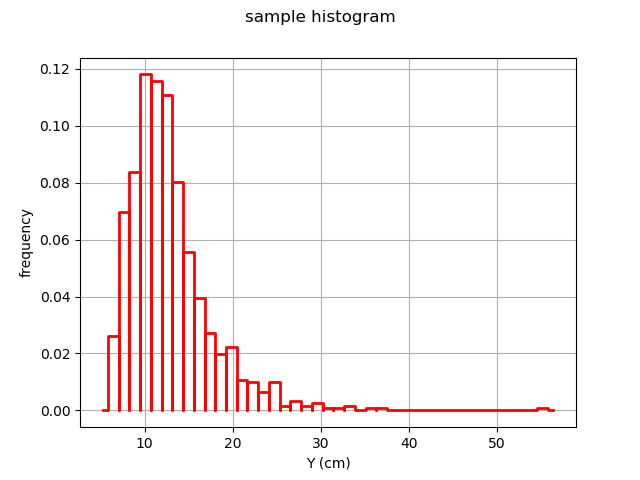

In [5]:
graph = ot.HistogramFactory().build(Y).drawPDF()
graph.setXTitle("Y (cm)")
graph.setLegends([""])
graph

In [8]:
XRV = ot.RandomVector(myDistribution)
YRV = ot.RandomVector(model, XRV)
YRV.setDescription(['Y (cm)'])

In [28]:
myEvent = ot.Event(YRV, ot.Greater(), 30.)
experiment = ot.MonteCarloExperiment()
myAlgo = ot.ProbabilitySimulationAlgorithm(myEvent, experiment)
myAlgo.setMaximumOuterSampling(100000)
myAlgo.setBlockSize(10000)
myAlgo.setMaximumCoefficientOfVariation(0.005)
myAlgo.run()

Probability estimate=0.005590
Sample size = 7120000


In [30]:
result = myAlgo.getResult()
pf = result.getProbabilityEstimate()
print('Probability estimate=%.6f' % (pf))
samplesize = result.getOuterSampling() * result.getBlockSize()
print("Sample size = %d" % (samplesize))

Probability estimate=0.005590
Sample size = 7120000


In [36]:
alpha = 0.05

In [37]:
conflen = result.getConfidenceLength(1-alpha)
conflen

0.00010953688446310513

In [39]:
print("%.2f%% Confidence interval = [%f,%f]" % ((1-alpha)*100, pf-conflen/2,pf+conflen/2))

95.00% Confidence interval = [0.005536,0.005645]
